## Importing needed library

>Note : I use gymnasium to replace gym in the sample code of tutorial as gym is no longer maintained. Some library will be imported later but does not require additional installation as they are standard library in python

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

GOAL = 195

## Task 1
Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

In [2]:
#Building env
env = gym.make("CartPole-v1")

In [3]:
#Taking action {0,1} take represents moving left or right
env.action_space

Discrete(2)

In [4]:
#A box type observation space that specify the upper limit and lower limit of observation
#Cart Position
#Cart Velocity
#Pole Angle
#Pole Angular Velocity
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [5]:
def plot_rewards(rewards):
    plt.axhline(y = GOAL, linestyle = '--', color = 'red', label = 'Goal reward')
    
    x = np.arange(len(rewards))
    
    slope, intercept = np.polyfit(x, rewards, 1)
    
    plt.plot(x, slope * x + intercept, color='orange', linestyle = '--', label = 'reward trend')
    plt.plot(rewards)
    plt.legend(loc = 'best')
    plt.show()

---
Since the observation space is continuous, we could use a Deep Q Learning to replace the Q matrix of original Q learning

In [6]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, hidden_dim = 128):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Here we replace the q matrix of the original q learning by using the DQL

The steps still follow the original q learning
1. Initialize Q
2. For each episode, initialize the original state
3. Choose action from the Q value using epsilon greedy
4. Update Q
5. Using the new state and repeat


The train equation is given by:

$$ Q(s, a) = R + \gamma Q(s', \pi(s,a)) $$



In [7]:
def epsilon_greedy(Q_value, eps, n_action):
    action = torch.argmax(Q_value)
    action_arr = np.arange(n_action)
    #if a* != a, then the probability will be eps / |A|
    
    p = [eps / n_action for x in range(n_action)]
    
    #if a* == a, the the probability will be 1 - eps + eps / n_action
    p[action] = 1 - eps + eps / n_action
    
    #Choose the action from a weighted sample
    #This ensure a bit randomness in our model
    greedy_choice = np.random.choice(action_arr, 1, p = p)
    
    return greedy_choice

def train(episodes, env, model, gamma = 0.9, eps = 0.9):
    rewards = []
    #We use Huber loss for the loss function
    criterion = nn.SmoothL1Loss()
    optimizer = Adam(model.parameters(), 0.001)
    for episode in range(episodes):
        #Get the initial state of the environment
        observation, info = env.reset()
        q_value = model(torch.from_numpy(observation))
        
        total_reward = 0
        while True:
            #Choose the action from the current q value
            action = epsilon_greedy(q_value, eps, 2).item()
            
            #Get into a new state and observe reward
            new_observation, reward, terminated, truncated, info = env.step(action)
            
            #This is an important step
            #Make sure the model learns from the last step and can learn how to avoid terminated state
            if terminated or truncated:
                q_value[action] = reward
                loss = criterion(q_value, model(torch.from_numpy(observation)))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                break
                
            else:
                q_value_next = model(torch.from_numpy(new_observation))
                q_value[action] = reward + gamma * torch.max(q_value_next)
                loss = criterion(q_value, model(torch.from_numpy(observation)))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            q_value = model(torch.from_numpy(new_observation))
            observation = new_observation
            total_reward += reward
        #modify the eps 
        #eps decay
        eps = max(eps*0.99, 0.01)
        
        rewards.append(total_reward)
        
        if (episode + 1) % 50 == 0:
            print("Average Reward [{} / {}] : {}".format(episode + 1, episodes, sum(rewards)/len(rewards)))
    return rewards
            

### Note:

> You could run this line of code if you want to see the training results as the training should take less than 10 seconds. This model will not be used in the final testing. Thus, checkpoint file is not provided

In [8]:
#define Q matrix using neural network
policy_network = DQN(4, 2)
rewards = train(200, env, policy_network)

/Users/paulzhang/miniforge3/envs/cartpole_env/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Average Reward [50 / 200] : 22.34
Average Reward [100 / 200] : 28.49
Average Reward [150 / 200] : 46.9
Average Reward [200 / 200] : 45.55


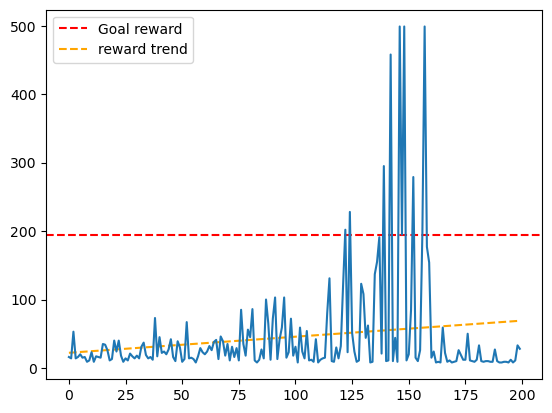

In [9]:
plot_rewards(rewards)

---

**The current Q network is not performing well, as it often only achieves an average reward of around 30+. Some potential drawbacks exist in the current network that might be causing this issue:**

1. The agent only learns from the most recent experience, which might cause it to get stuck at some point.
2. The q value is updated based on the q value that the network produces, which might lead to instability in the network.

**To address these issues, we can make the following improvements:**

1. Store old experiences in a memory buffer and sample a mini-batch from the buffer to train the Q network at each time step.
2. Use a separate target network to predict the Q value and update the weights of the target network to match the Q network.

By implementing these improvements, we can expect the Q network to perform better and achieve higher average rewards.



In [10]:
from collections import deque
import random

class ReplayMemory(object):

    def __init__(self, capacity):
        #A queue where has maximum capacity 
        self.memory = deque([], maxlen=capacity)

    def push(self, observation, reward, action, new_observation, done):
        """Save a transition"""
        #When it reaches the capacity, the first one will be auto pop out
        #Oldest memory in the buffer will be pop out
        self.memory.append([observation, reward, action, new_observation, done])

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
CAPACITY = 1024
BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def optimize_model(memory_buffer, policy_model, target_model, gamma, criterion, optimizer):
    #Sampled a mini batch of memory from the memory buffer
    experiences = memory_buffer.sample(BATCH_SIZE)
    
    '''q_values = torch.Tensor([]).to(device)
    target = torch.Tensor([]).to(device)
    
    #For each experience
    for experience in experiences:
        current_state, reward, action, new_observation, done = experience
        #Q(s)
        q_value = policy_model(torch.from_numpy(current_state).to(device))
        
        if done:
            q_value[action] = reward
        else:
            #V(S) from the target network
            q_value_next = target_model(torch.from_numpy(new_observation).to(device))
            #Q(s, a) = R + gamma * Q(s, a) <-- the max from the upper V(S)
            q_value[action] = reward + gamma * torch.max(q_value_next)
            
        q_values = torch.cat([q_values, policy_model(torch.from_numpy(current_state))])
        target = torch.cat([target, q_value])'''
    
    #Optimize algorithm for training
    #Faster training
    #It's doing the same thing as the annotated code above
    current_state = torch.Tensor([experience[0] for experience in experiences]).to(device)
    reward = torch.Tensor([experience[1] for experience in experiences]).to(device)
    action = torch.tensor([experience[2] for experience in experiences], dtype = torch.long)
    new_state = torch.Tensor([experience[3] for experience in experiences]).to(device)
    done = torch.tensor([experience[4] for experience in experiences], dtype = torch.bool)
    not_done = torch.logical_not(done)
    
    q_values = policy_model(current_state)
    
    targets = policy_model(current_state)
    targets[done, action[done]] = reward[done]
    q_values_next = target_model(new_state)
    
    targets[not_done, action[not_done]] = reward[not_done] + gamma * torch.max(q_values_next, dim = -1)[0][not_done]
    
    
    loss = criterion(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        

def train_replay(episodes, env, policy_model, target_model, gamma = 0.9, eps = 0.9):
    rewards = []
    criterion = nn.SmoothL1Loss()
    optimizer = Adam(policy_model.parameters(), 0.001)
    memory_buffer = ReplayMemory(CAPACITY)
    for episode in range(episodes):
        observation, info = env.reset()
        q_value = policy_model(torch.from_numpy(observation).to(device))
        
        if (episode + 1) % 5 == 0:
            target_model.load_state_dict(policy_model.state_dict())
        total_reward = 0
        while True:
            
            action = epsilon_greedy(q_value, eps, 2).item()
            
            new_observation, reward, terminated, truncated, info = env.step(action)
            
            '''memory_buffer.push(observation, reward, action, new_observation, terminated or truncated)'''
            memory_buffer.push(observation.tolist(), reward, action, new_observation.tolist(), terminated or truncated)
            
            #Only difference compare to the training without replay
            if len(memory_buffer) > BATCH_SIZE:
                optimize_model(memory_buffer, policy_model, target_model, gamma, criterion, optimizer)
                
            if terminated or truncated:
                break
            
            q_value = target_model(torch.from_numpy(new_observation).to(device))
            observation = new_observation
            total_reward += reward
        eps = max(eps*0.99, 0.01)
        
        rewards.append(total_reward)
        
        if (episode + 1) % 50 == 0:
            print("Average Reward [{} / {}] : {}".format(episode + 1, episodes, sum(rewards)/len(rewards)))
    return rewards

## Note

- This training will take longer than the previous one. 
- You can try training the model with a small capacity and batch size, but the results might be random. A 150+ average reward can be achieved with sufficient training.

Alternatively:

- You can skip the training section and load the provided state dict with the code in the cells below. 
- This will guarantee that the model will reach the goal.


I ran a few experiments with these parameters

| Episodes | BatchSize | Capacity |
| -------- | --------- | -------- |
| 600      | 16        | 512      |
| 600      | 64        | 1024     |
| 600      | 128        | 4096     |

The total running time should be around **1-2 minutes** (on Mac M1 16GB)



The training process can be quite random, so it is possible that running the training code will not result in reaching the goal of 195+ average reward. Therefore, I suggest loading the state_dict, which represents one of the best results from these experiments and should yield much higher rewards than 195+.


In [13]:
import time

policy_network = DQN(4, 2).to(device)
target_network = copy.deepcopy(policy_network).to(device)
policy_network.train()
target_network.eval()
start_time = time.time()
rewards = train_replay(600, env, policy_network, target_network)
print("Training time : {} min".format((time.time() - start_time) / 60))

Average Reward [50 / 600] : 34.96
Average Reward [100 / 600] : 59.39
Average Reward [150 / 600] : 106.93333333333334
Average Reward [200 / 600] : 146.195
Average Reward [250 / 600] : 163.032
Average Reward [300 / 600] : 169.47
Average Reward [350 / 600] : 171.91142857142856
Average Reward [400 / 600] : 178.9425
Average Reward [450 / 600] : 180.62222222222223
Average Reward [500 / 600] : 178.584
Average Reward [550 / 600] : 180.32545454545453
Average Reward [600 / 600] : 177.72166666666666
Training time : 1.4422037839889525 min


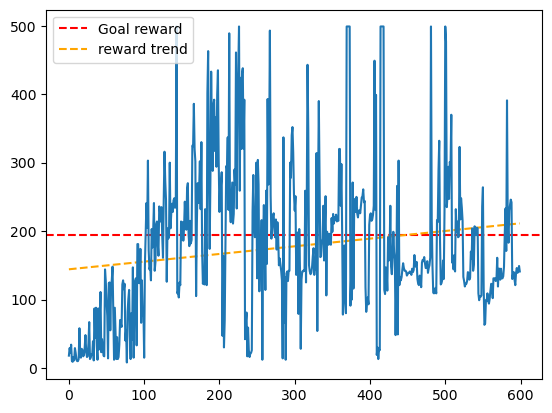

In [14]:
plot_rewards(rewards)
#Doesn't actually matters here which state dict you use
#target network has the same param with policy network here
state_dict = {'state_dict' : target_network.state_dict(),
             'episodes' : 600,
             'max_rewards' : max(rewards)}

#torch.save(state_dict, "checkpoints/q_network_600episodes_1024Cap_64Batch.pth.tar")

In [15]:
q_network = DQN(4,2)
ckpt = torch.load("checkpoints/q_network_600episodes_1024Cap_64Batch.pth.tar")
q_network.load_state_dict(ckpt['state_dict'])
q_network.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

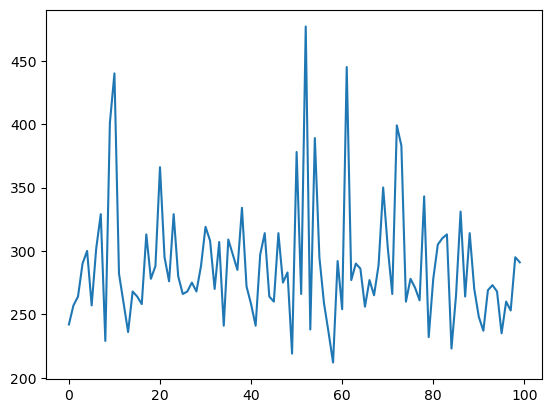

In [20]:
def test(episodes, env, policy_network):
    rewards = []
    for episode in range(episodes):
        observation, info = env.reset()
        total_reward = 0
        q_value = policy_network(torch.from_numpy(observation).to(device))
        while True:
            
            #action = epsilon_greedy(q_value, 0.01, 2).item()
            action = torch.argmax(q_value).item()
            
            new_observation, reward, terminated, truncated, info = env.step(action)
            
            total_reward += reward
            
            if terminated or truncated:
                break
            
            obseravtion = new_observation
            q_value = policy_network(torch.from_numpy(new_observation).to(device))
        rewards.append(total_reward)
    return rewards

test_rewards = test(100, env, q_network)
plt.plot(test_rewards)

In [21]:
print("Average cumulative reward:", sum(test_rewards) / len(test_rewards))
print("Is my agent good enough?", sum(test_rewards) / len(test_rewards) > 195)

Average cumulative reward: 288.64
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Render one episode played by the developed RL agent on Jupyter. 

In [22]:
env_record = gym.make('CartPole-v1', render_mode = "rgb_array_list")
env_record = RecordVideo(env_record, './video')

def record(env, policy_network):
    observation, info = env.reset()
    total_reward = 0
    q_value = policy_network(torch.from_numpy(observation).to(device))
    while True:
        env.render()
        #action = epsilon_greedy(q_value, 0.01, 2).item()
        action = torch.argmax(q_value).item()

        new_observation, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        if terminated or truncated:
            return total_reward

        obseravtion = new_observation
        q_value = policy_network(torch.from_numpy(new_observation).to(device))
        
    
    


/Users/paulzhang/miniforge3/envs/cartpole_env/lib/python3.8/site-packages/gymnasium/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/paulzhang/Documents/NTU/SC3000/Assignment/Lab1/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [25]:
total_reward = record(env_record, q_network)
print("=============")
print("The reward in this video is {}".format(total_reward))

/Users/paulzhang/miniforge3/envs/cartpole_env/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video /Users/paulzhang/Documents/NTU/SC3000/Assignment/Lab1/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/paulzhang/Documents/NTU/SC3000/Assignment/Lab1/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/paulzhang/Documents/NTU/SC3000/Assignment/Lab1/video/rl-video-episode-0.mp4
The reward in this video is 315.0


---

Copy from the Sample show_video code from the tutorial provided

In [26]:
from IPython.display import HTML
from IPython import display as ipythondisplay
import glob
import io
import base64

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [27]:
show_video()

## Reference material

I refer to these website when building this jupyter notebook, but most of the code in this notebook are done by myself after reading these materials. I refer to these materials for the whole procedure of the deep q learning and the idea of experience replay

<br></br>

**Some improvements:**
- Using epsilon greedy strategy in class when making action
- Optimize the replay algorithm so that we can avoid the for loop in each memory that would drastically slow down the process

<br></br>


**Some flaws I notice in these tutorials:**
- In the Deep Q learning for cartpole (second website in the reference material), the q learning without replay does not works with the default parameters. I copy her code and perform the q learning several times but the rewards never reach to the graph she showed in the website. Perhaps she use other tricks or parameters in the training procedure. (Or I'm performing the training in a wrong way :D )

- In pytorch's official tutorial, the training does not reaches to a good end result as shown in the graph. From my experiments, a large memory and batch size does not necessary guarantee a better result. You should always start with a lower memory buffer size, batch size, and episode number and gradually increase the parameters to find a good combination
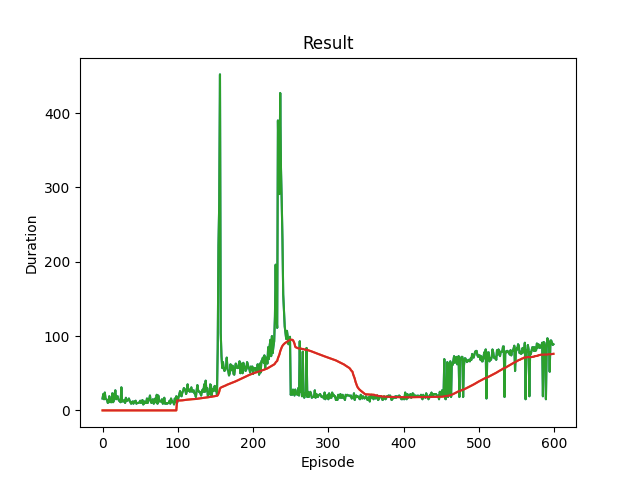



**[Reinforcement Tutorial from pytorch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training-loop)**

**[Deep Q Learning for cartpole](https://towardsdatascience.com/deep-q-learning-for-the-cartpole-44d761085c2f)**
